In [3]:
### Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import string
import missingno as msno
import scipy
import i2bmi as i2bmi

import statsmodels as sms

from scipy.stats import wilcoxon
from statistics import mean
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import RidgeCV, LarsCV, LassoLarsCV
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from statannotations.Annotator import Annotator

from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline

from tools.imputers import CustomIterativeImputer,Interpolator
from tools.stats import compare_imputers
# Jupyter notebook - widen cells
#i2bmi.jupyter_widen()

In [5]:
### Load data

# directory containing raw datasets
data_dir = 'data/'

# Name of data file
file_name = 'Audiograms.xlsx'

file_path = os.path.join(data_dir, file_name)

# Load dataframe from excel file
df = pd.read_excel(file_path)

audiogram_cols = [
    '125hz', 
    '250hz', 
    '500hz',
    '750hz', 
    '1000hz', 
    '1500hz', 
    '2000hz', 
    '3000hz', 
    '4000hz', 
    '6000hz',
    '8000hz'
]

# Remove patients under 18
df = df.loc[df['Age'] >= 18, :]

# Remove audiograms without at least 1 frequency recorded
df = df.dropna(thresh=1, subset=audiogram_cols)

# Remove non-audiogram columns from dataset
df = df[audiogram_cols]

In [113]:
### Settings


data_min_max = (0, 120)       # Specify minimum and maximum audiogram values

n_sim = 10
n_sim_cv = 10
n_gridsearch_cv = 10
crit_thresh = (10, 20, 30)      
random_state = 0
verbose=3                       # Define verbosity of notebook output



# #Drop rate and dist comparison
# dist_types=['parent', 'random', 'skew-terminal', 'skew-central']
# rates=range(1, df.shape[1])  
# sizes=[None]
# noises=[None]
# drop_max=None

# Size comparison
# dist_types = ['parent']
# rates = ['parent']
# sizes = [20, 40, 80, 160, 320, 640, 1280, 2560]
# noises = [None]
# drop_max = 3


# Model selection
dist_types=['parent', 'random', 'skew-terminal', 'skew-central']
rates=['parent']
sizes=[None]
noises=[None]
drop_max=3





# Define estimators
estimators = {    
    
    # Constant imputation w/feature mean
    'Univariate' : (SimpleImputer(strategy='mean'), {'strategy' : ['mean', 'median', 'most_frequent']}),
    
    'Interpolation' : (Interpolator(method='linear'), {'method' : ['linear', 'pchip', 'cubicspline']}),

    # Linear regression - multiple imputation
    'MICE' : (CustomIterativeImputer(estimator=RidgeCV(),
                                min_value=data_min_max[0],
                                max_value=data_min_max[1],
                                tol=1e-3,
                                imputation_order='ascending',
                                sice_transform=False,
                                modify_sice=False),
           {
                'estimator' : [RidgeCV(), LassoLarsCV()],
               'initial_strategy' : ['linear', 'mean'],
               'mice_iter' : [3, 7, 15],
           }),   
    
    # K-nearest neighbors
    'K-nearest neighbors' : (KNNImputer(n_neighbors=10, weights='distance'),
          {
              'n_neighbors' : [3, 6, 10, 15, 25, 45, 70, 100],
              'weights' : ['uniform', 'distance']
          }),
    
#     # Gradient boosted trees
    'XGBoost' : (MultiOutputRegressor(XGBRegressor(learning_rate=0.01,
                                               n_estimators=750,
                                               max_depth=4,
                                          tree_method='hist',
                                          gamma=0,
                                          min_child_weight=2,
                                          subsample=0.5,
                                          reg_lambda=0.5,
                                          reg_alpha=0.5)),
         {
              'estimator__n_estimators':[500, 800],
             'estimator__max_depth':[3, 4, 5],
             'estimator__learning_rate':[0.01],
             'estimator__subsample':[0.25, 0.5, 0.75],

         }),
    
    # Multilayer perceptron
    'Neural network' : (MLPRegressor(max_iter=100),
             {
                  'hidden_layer_sizes' : [
                     
                     (64, 64),
                     (64, 64, 64),
                     (64, 64, 64, 64),
                     (128, 128),
                     (128, 128, 128),
                     (256, 256),
                     (256, 256, 256),

                     
                  ],

                 'learning_rate_init' : [
                     0.01,
                     0.005,
                 ]
             }),
    
    
}


error = compare_imputers(
    estimators=estimators,
    df=df,
    data_min_max=data_min_max,
    n_sim=n_sim,
    n_sim_cv=n_sim_cv,
    n_gridsearch_cv=n_gridsearch_cv,
    dist_types=dist_types,
    rates=rates,
    sizes=sizes,
    noises=noises,
    drop_max=drop_max,
    crit_thresh=crit_thresh,
    verbose=verbose,
    random_state=random_state
)



MICE best params:  {'initial_strategy': 'linear', 'mice_iter': 15}
MICE mean_scores:  [[18.85564109 18.94176202]
 [18.80306987 18.80523664]]
Model:MICE  Dist:parent  Rate:parent  Size:None  Noise:None  Sim:1  Fold:1  Ttime:76.5
MICE best params:  {'initial_strategy': 'linear', 'mice_iter': 15}
MICE mean_scores:  [[21.44142652 21.86681746]
 [21.26058758 21.26292783]]
Model:MICE  Dist:parent  Rate:parent  Size:None  Noise:None  Sim:1  Fold:2  Ttime:77.984375
MICE best params:  {'initial_strategy': 'mean', 'mice_iter': 15}
MICE mean_scores:  [[21.19876004 20.51114607]
 [20.67753768 20.4477427 ]]
Model:MICE  Dist:parent  Rate:parent  Size:None  Noise:None  Sim:1  Fold:3  Ttime:83.796875


KeyboardInterrupt: 

In [110]:
save_path = '***.csv'
error.to_csv(save_path)

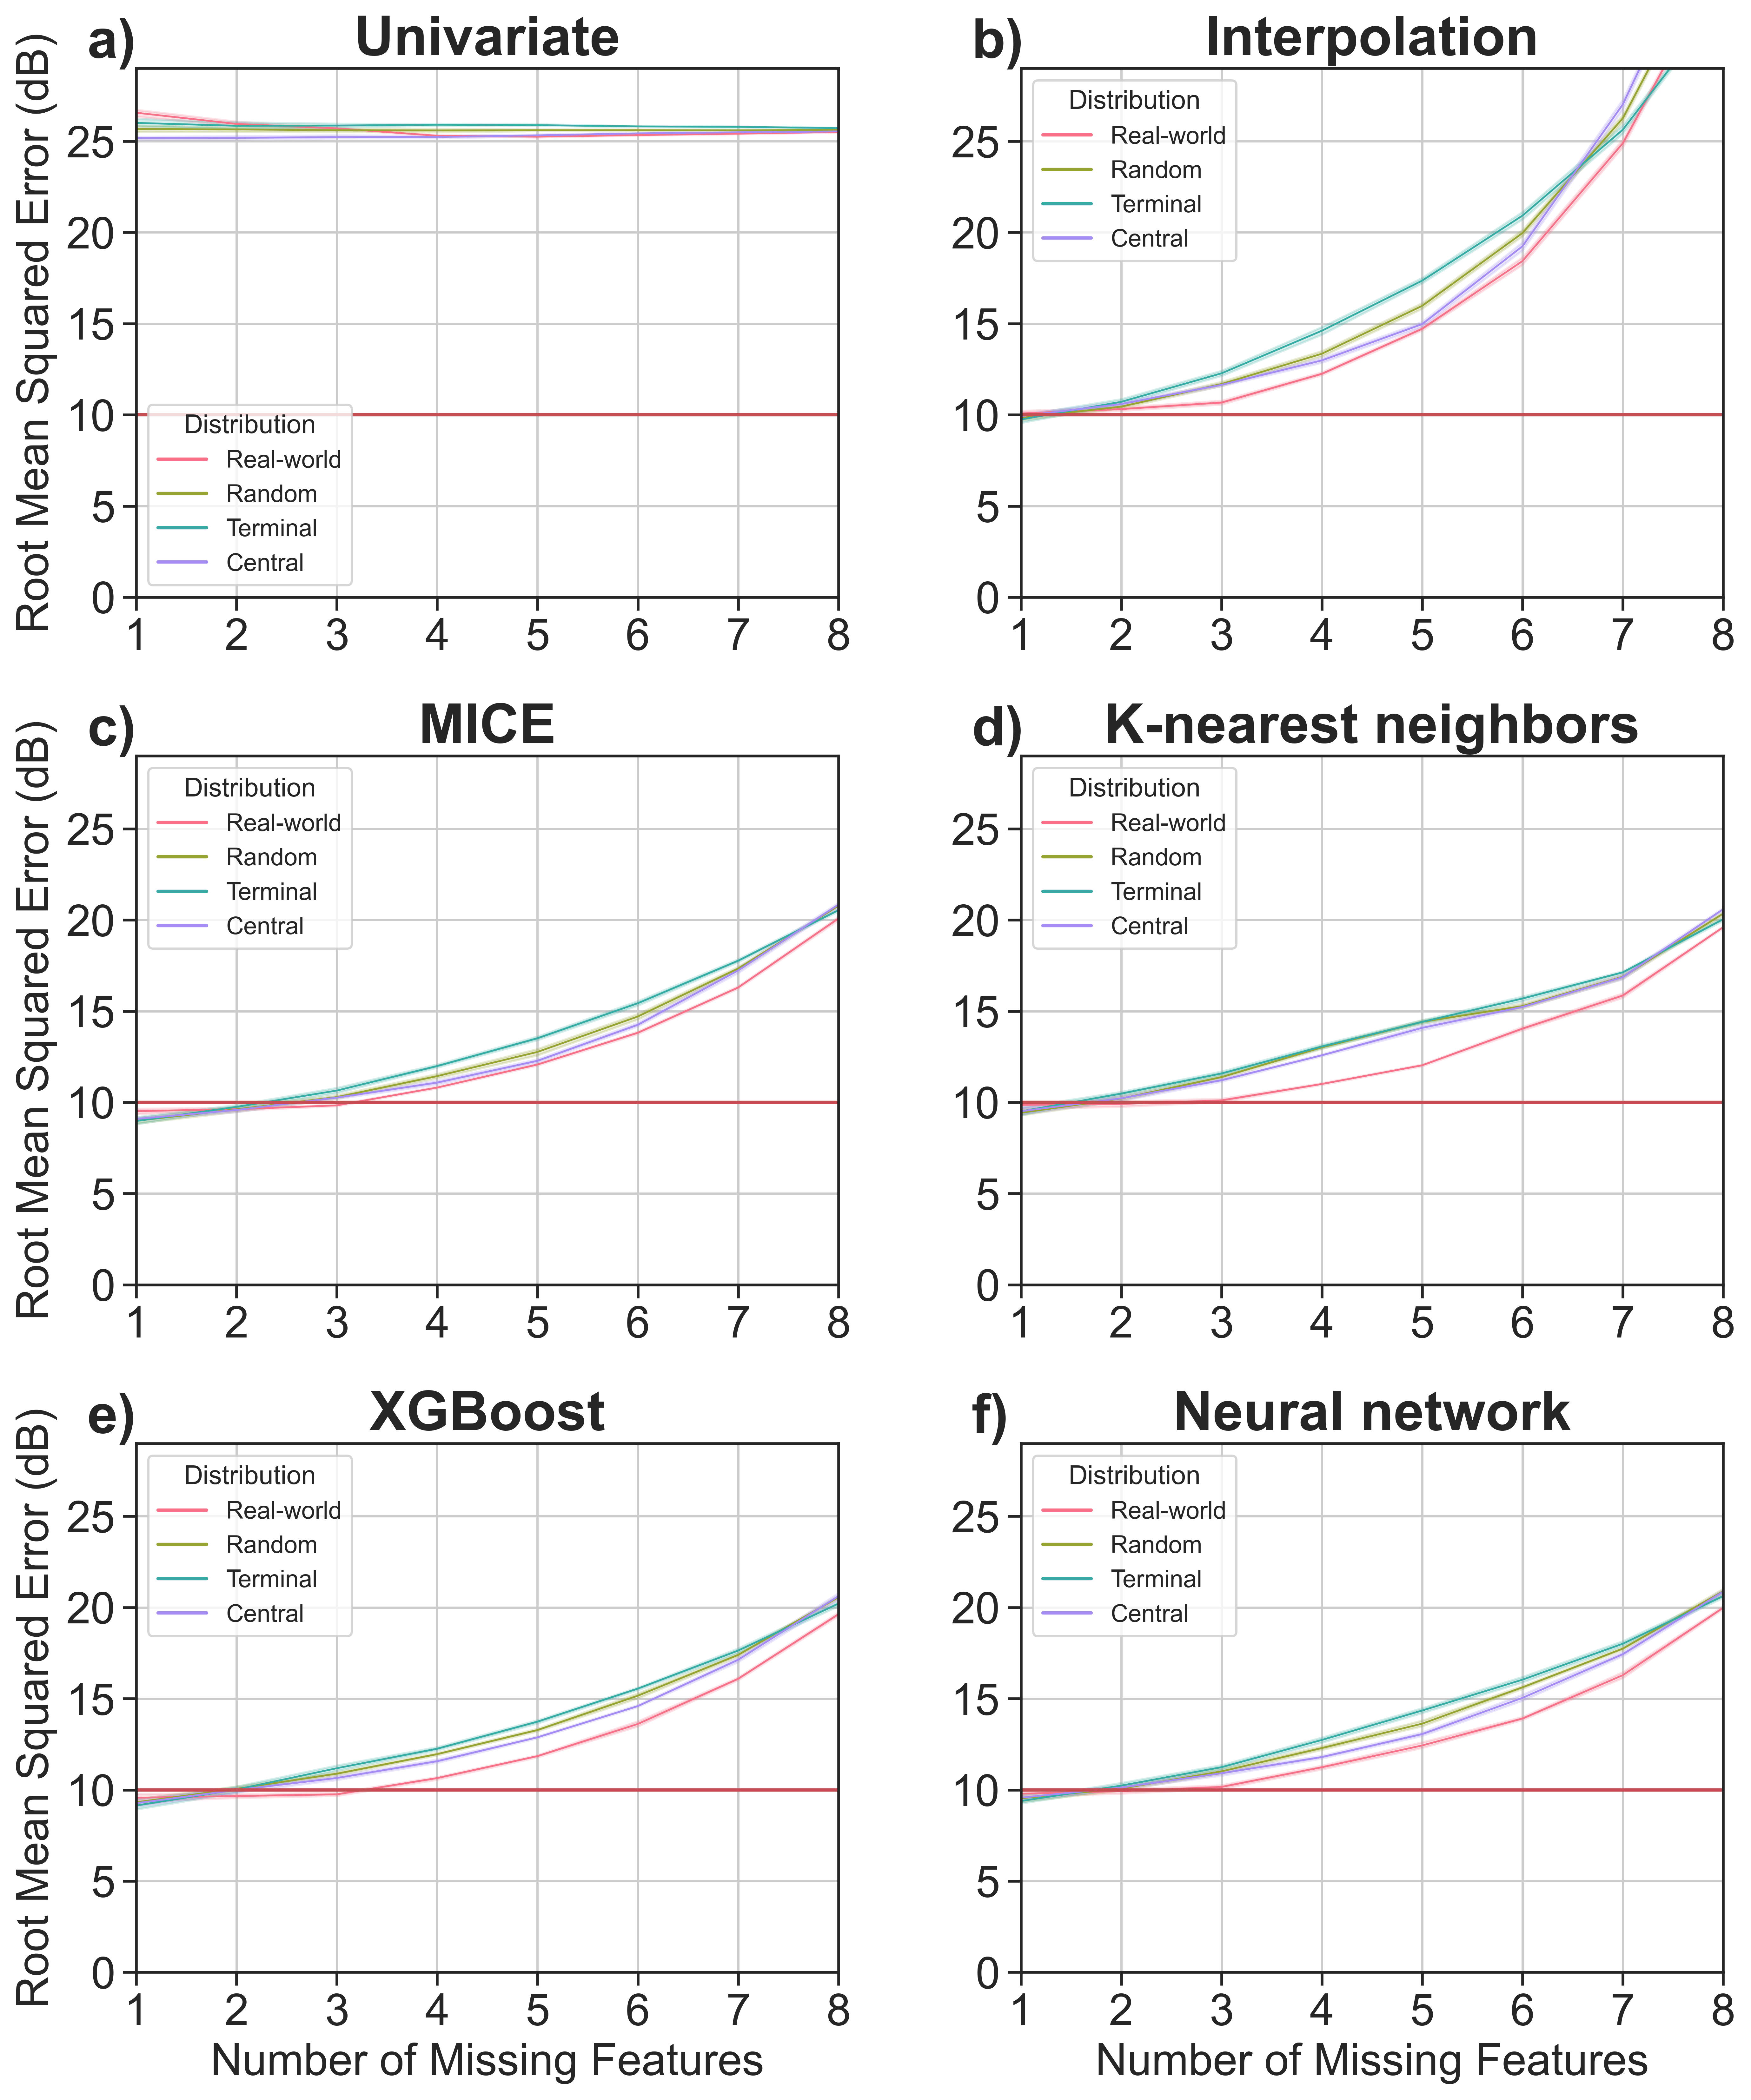

In [157]:
### Comparing random vs parent, 1-10 drops, lineplot

save_path = '***.csv') 
error = pd.read_csv(save_path)

mdict = {
    'MI' : 'Mean Imputation',
    'LI' : 'Linear Interpolation',
    'MICE' : 'MICE',
    'KNN' : 'K-nearest neighbors',
    'XGB' : 'XGBoost',
    'NN' : 'Neural Network',
    'parent' : 'Real-world',
    'random' : 'Random',
    'skew-terminal' : 'Terminal',
    'skew-central' : 'Central'
}

cdict = {
    'Dist Type': 'Distribution'
}


error = error.replace(mdict)
error = error.rename(columns=cdict)
error = error.loc[error['Distribution'] != 'parent-inverse']


ci = 99 
hue = 'Distribution'
x = 'Rate'
y = 'Root Mean Squared Error'
#y = 'Mean Absolute Error'

ylabel = 'Root Mean Squared Error (dB)'
xlim = (1, error['Rate'].max())

ylim = (0, 29)

font_subheader = {'size': 20}
title_subheader = {'size': 25, 'weight': 'bold'}
abc_size=25
ticksize = 20

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15),  dpi=500, sharey=False)

_ = plt.subplots_adjust(
    left  = 0,  # the left side of the subplots of the figure
    right = 1,    # the right side of the subplots of the figure
    bottom = 0.1,   # the bottom of the subplots of the figure
    top = 0.9,      # the top of the subplots of the figure
    wspace = 0.26,   # the amount of width reserved for blank space between subplots
    hspace = 0.3,   # the amount of height reserved for white space between subplots
)

sns.set_theme()
palette = sns.color_palette('husl', error[hue].nunique())
sns.set_style("ticks", {'axes.grid': True})


n = 0
for model, ax in zip(error['Model'].unique(), axes.ravel()):

    _ = sns.lineplot(ax=ax,
                     x=x,
                     y=y,
                     hue=hue,
                     data=error.loc[error.Model == model, :],
                     err_style='band',
                     ci=ci,
                     palette=palette,
                     linewidth=0.8)

    _ = _.axhline(10, color='r')
    
    _ = ax.set(ylim=ylim, xlim=xlim)

    _ = ax.set_yticks(np.arange(0, 26, 5))
    
    _ = ax.set_xticks(np.arange(xlim[0], xlim[1]+1, 1))


    _ = ax.tick_params(axis='x', labelsize=ticksize)
    _ = ax.tick_params(axis='y', labelsize=ticksize)

    
    
    
    if n in [0, 2, 4]:
        _ = ax.set_ylabel(ylabel, fontdict=font_subheader)
    else:
        _ = ax.set_ylabel('', fontdict=font_subheader)
    
    
    if n in [4, 5]:
        _ = ax.set_xlabel('Number of Missing Features', fontdict=font_subheader)
    else:
        _ = ax.set_xlabel('', fontdict=font_subheader)
        
    _ = ax.set_title('%s' % model, fontdict=title_subheader)
    n = n+1

for n, ax in enumerate(axes.flat):   
    
    _ = ax.text(-0.07, 1.02, (string.ascii_lowercase[n] + ')'), transform=ax.transAxes, 
            size=abc_size, weight='bold')
        
plt.show()



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mean vs. Median: ***
Mean vs. Mode: ***
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mean vs. Median: ***
Mean vs. Mode: ***
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mean vs. Median: ***
Mean vs. Mode: ***


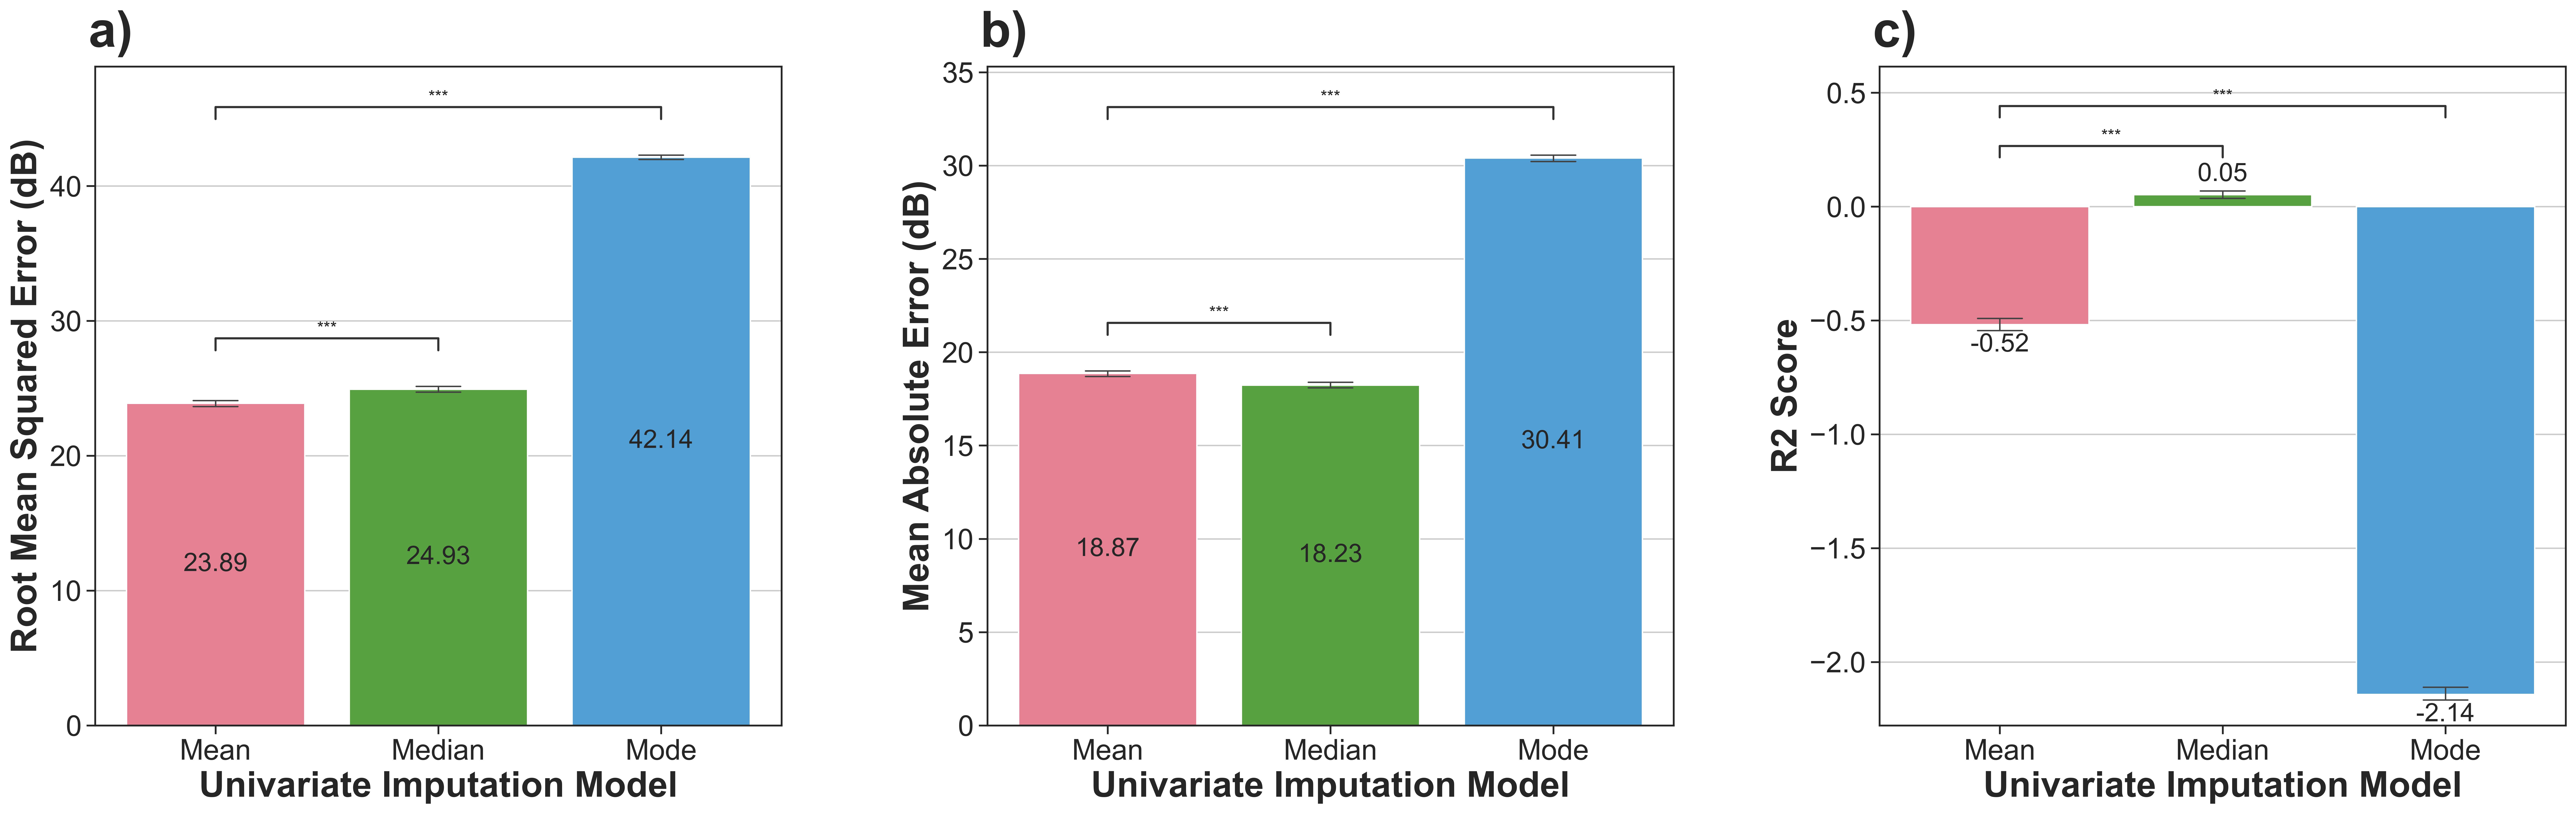

In [131]:
### Univariate Imputation Models


error = pd.read_csv('./Figures-AGI/9_12_22_UVI_Interpolation.csv')

error = error[error.Model != 'Pchip']
error = error[error.Model != 'Linear Interpolation']
error = error[error.Model != 'Cubic Spline'].copy(deep=True)
error.Model = error.Model.str.replace('Feature ', '')


# error = error[error.Model != 'Feature Mean']
# error = error[error.Model != 'Feature Median']
# error = error[error.Model != 'Feature Mode']

# error.Model = error.Model.str.replace('Pchip', 'PCHIP')
# error.Model = error.Model.str.replace('Linear Interpolation', 'Linear')



ci = 95
hue = 'Model'
#x = 'Drop Rate'
#x = 'Univariate Model'

xlim = (-1, 0)

xlabel = 'Univariate Imputation Model'

palette = sns.color_palette('husl', error[hue].nunique())

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8),  dpi=500, sharey=False)

_ = plt.subplots_adjust(
    left  = 0,  # the left side of the subplots of the figure
    right = 1,    # the right side of the subplots of the figure
    bottom = 0.1,   # the bottom of the subplots of the figure
    top = 0.9,      # the top of the subplots of the figure
    wspace = 0.3,   # the amount of width reserved for blank space between subplots
    hspace = 0.24,   # the amount of height reserved for white space between subplots
)

font_subheader = {
    'size': 25,
    'weight': 'bold'
}

y_list = [
    'Root Mean Squared Error', 'Mean Absolute Error', 'R2 Score', 
]

ylim_list = [
    (0, 50),  # RMSE
    (0, 35),  # MAE
    (-3, 1.0), # R
]

abc_size=35
ticksize = 20

bar_label_size = 18

#_ = plt.subplots_adjust(hspace=0.2, left=0, right=1)

sns.set_theme()

sns.set_style("ticks", {'axes.grid': True})

for y, ylim, ax in zip(y_list, ylim_list, axes.ravel()):
        
    #     else: 

    plotting_parameters = {
        'x': hue,
        'y': y,
        'data': error,
        'palette': palette,
        'capsize': 0.2,
        'errwidth': 1
    }

    _ = sns.barplot(ax=ax, **plotting_parameters)

    _ = ax.tick_params(axis='x', labelsize=ticksize)
    _ = ax.tick_params(axis='y', labelsize=ticksize)
    _ = ax.set_ylabel(y, fontdict=font_subheader)
    _ = ax.set_xlabel(x, fontdict=font_subheader)

    
    pairs = [
        ('Mean', 'Median'),
        ('Mean', 'Mode'),
    ]

    _ = ax.tick_params(axis='x', labelsize=ticksize)
    _ = ax.tick_params(axis='y', labelsize=ticksize)

    if (y == 'Root Mean Squared Error'):
        y = y + ' (dB)'
        formatted_pvalues = ['***', '***']
        ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='center', fontsize=bar_label_size)
    
    if (y == 'Mean Absolute Error'):
        y = y + ' (dB)'
        formatted_pvalues = ['***', '***']
        ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='center', fontsize=bar_label_size)

    if (y == 'R2 Score'):
        formatted_pvalues = ['***', '***']
        ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='edge', padding=6, fontsize=bar_label_size)
    

    _ = ax.set_ylabel(y, fontdict=font_subheader)
    _ = ax.set_xlabel(xlabel, fontdict=font_subheader)
    
    annotator = Annotator(ax, pairs, **plotting_parameters)

    annotator.set_custom_annotations(formatted_pvalues)

    annotator.annotate()

for n, ax in enumerate(axes.flat):   


    _ = ax.text(-0.01, 1.03, (string.ascii_lowercase[n] + ')'), transform=ax.transAxes, 
            size=abc_size, weight='bold')
    
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Linear vs. PCHIP: ***
Linear vs. Cubic Spline: ***
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Linear vs. PCHIP: ***
Linear vs. Cubic Spline: ***
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Linear vs. PCHIP: **
Linear vs. Cubic Spline: ***


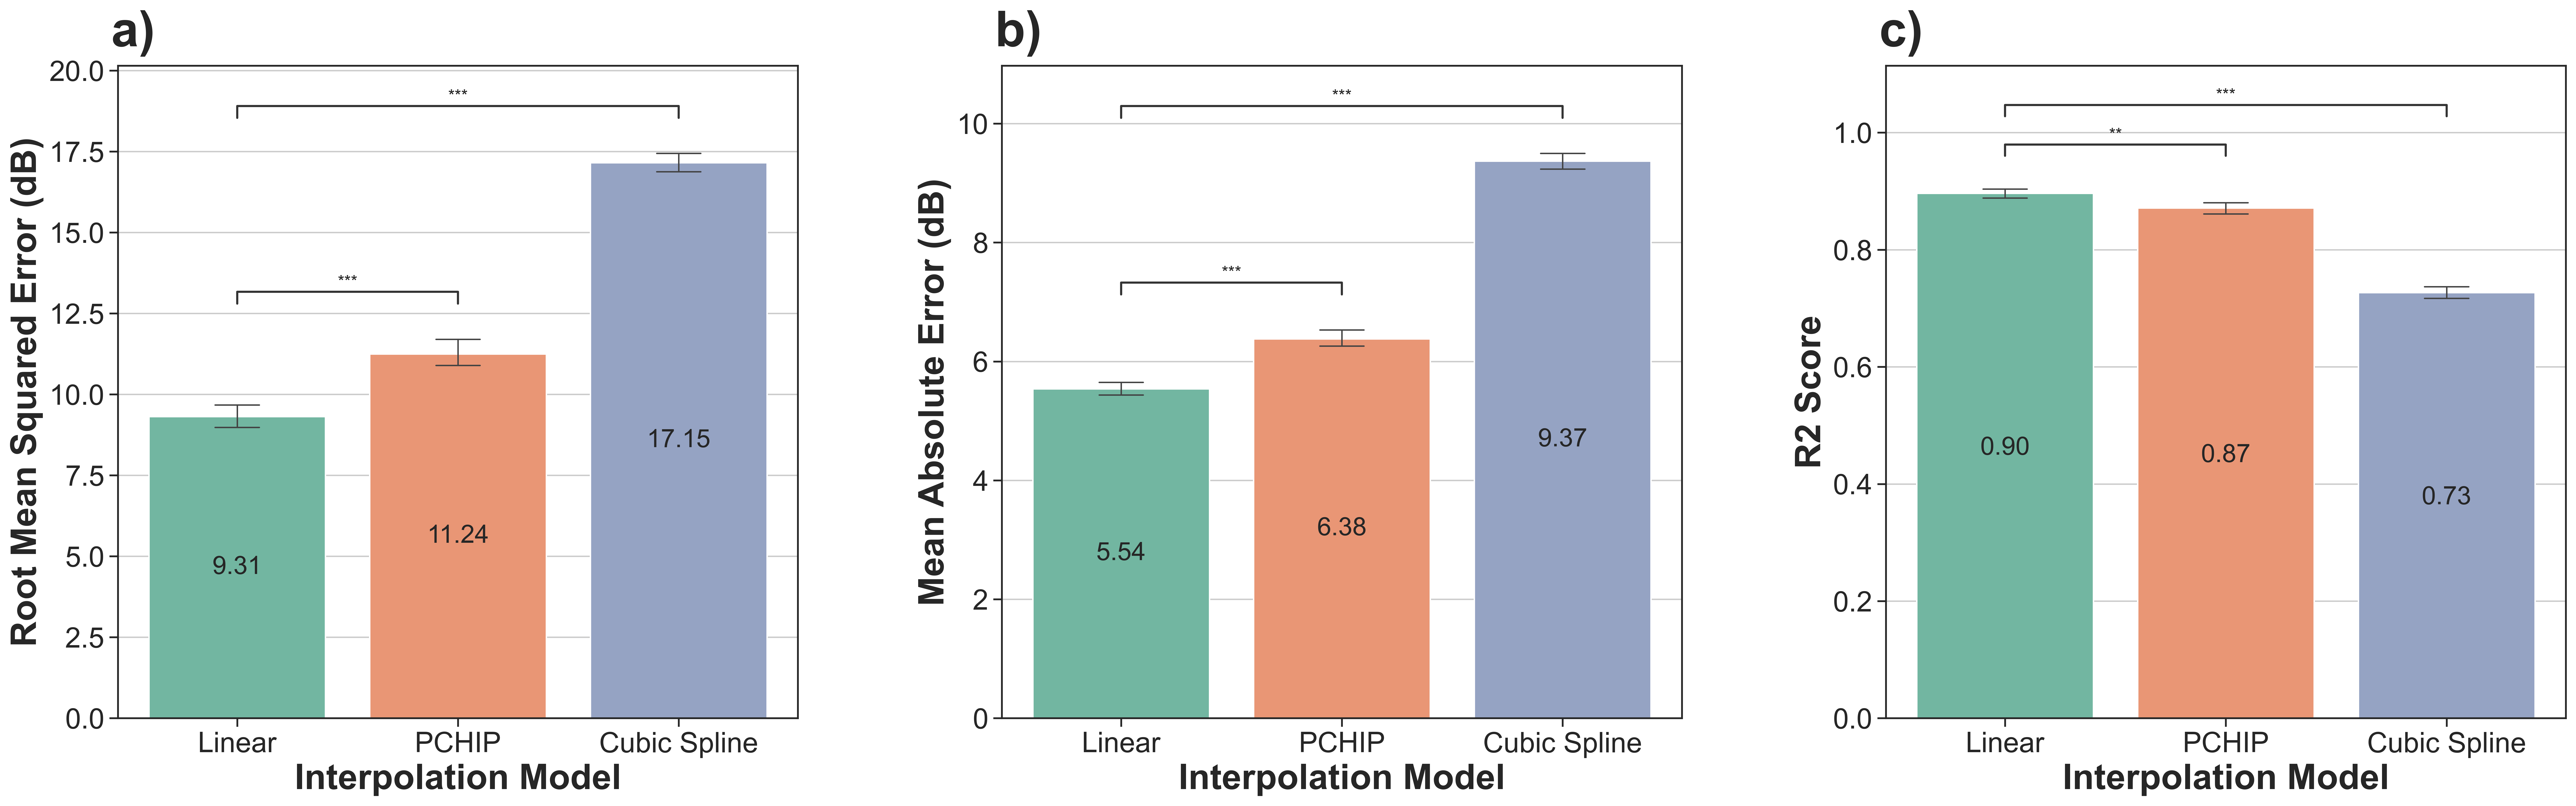

In [128]:
### Interpolation Models

error = pd.read_csv('./Figures-AGI/9_12_22_UVI_Interpolation.csv')

# error = error[error.Model != 'Pchip']
# error = error[error.Model != 'Linear Interpolation']
# error = error[error.Model != 'Cubic Spline'].copy(deep=True)
# error.Model = error.Model.str.replace('Feature ', '')


error = error[error.Model != 'Feature Mean']
error = error[error.Model != 'Feature Median']
error = error[error.Model != 'Feature Mode']

error.Model = error.Model.str.replace('Pchip', 'PCHIP')
error.Model = error.Model.str.replace('Linear Interpolation', 'Linear')



ci = 95
hue = 'Model'
#x = 'Drop Rate'
#x = 'Univariate Model'

xlim = (-1, 0)

xlabel = 'Interpolation Model'

palette = sns.color_palette('Set2', error[hue].nunique())

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8),  dpi=500, sharey=False)

_ = plt.subplots_adjust(
    left  = 0,  # the left side of the subplots of the figure
    right = 1,    # the right side of the subplots of the figure
    bottom = 0.1,   # the bottom of the subplots of the figure
    top = 0.9,      # the top of the subplots of the figure
    wspace = 0.3,   # the amount of width reserved for blank space between subplots
    hspace = 0.24,   # the amount of height reserved for white space between subplots
)

font_subheader = {
    'size': 25,
    'weight': 'bold'
}

y_list = [
    'Root Mean Squared Error', 'Mean Absolute Error', 'R2 Score', 
  #  '% Misses > 10'#, '% Errors > 20db', '% Errors > 30db'
]

ylim_list = [
    (0, 50),  # RMSE
    (0, 35),  # MAE
    (-3, 1.0), # R2

#    (0, 100),  # %>10
#     (0, 100),  # %>20
#     (0, 100),  # %>30

]

abc_size=35
ticksize = 20

bar_label_size = 18

#_ = plt.subplots_adjust(hspace=0.2, left=0, right=1)

sns.set_theme()

sns.set_style("ticks", {'axes.grid': True})

for y, ylim, ax in zip(y_list, ylim_list, axes.ravel()):
        
    #     else: 

    plotting_parameters = {
        'x': hue,
        'y': y,
        'data': error,
        'palette': palette,
        'capsize': 0.2,
        'errwidth': 1
    }

    _ = sns.barplot(ax=ax, **plotting_parameters)

    _ = ax.tick_params(axis='x', labelsize=ticksize)
    _ = ax.tick_params(axis='y', labelsize=ticksize)
    _ = ax.set_ylabel(y, fontdict=font_subheader)
    _ = ax.set_xlabel(x, fontdict=font_subheader)


    # for n, ax in enumerate(axes.flat):   


    #     _ = ax.text(-0.22, 0.98, (string.ascii_lowercase[n] + ')'), transform=ax.transAxes, 
    #             size=abc_size, weight='bold')

    pairs = [
        ('Linear', 'PCHIP'),
        ('Linear', 'Cubic Spline'),
    ]
    
#     pairs = [
#         ('Mean', 'Median'),
#         ('Mean', 'Mode'),
#     ]

    _ = ax.tick_params(axis='x', labelsize=ticksize)
    _ = ax.tick_params(axis='y', labelsize=ticksize)

    if (y == 'Root Mean Squared Error'):
        y = y + ' (dB)'
        formatted_pvalues = ['***', '***']
        ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='center', fontsize=bar_label_size)
    
    if (y == 'Mean Absolute Error'):
        y = y + ' (dB)'
        formatted_pvalues = ['***', '***']
        ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='center', fontsize=bar_label_size)

    if (y == 'R2 Score'):
        formatted_pvalues = ['**', '***']
        ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='center', padding=5.5, fontsize=bar_label_size)
    

    _ = ax.set_ylabel(y, fontdict=font_subheader)
    _ = ax.set_xlabel(xlabel, fontdict=font_subheader)
    
    annotator = Annotator(ax, pairs, **plotting_parameters)

    annotator.set_custom_annotations(formatted_pvalues)

    annotator.annotate()

for n, ax in enumerate(axes.flat):   


    _ = ax.text(-0.01, 1.03, (string.ascii_lowercase[n] + ')'), transform=ax.transAxes, 
            size=abc_size, weight='bold')
    
plt.show()

C:\Users\ShewLab\AppData\Local\Temp\ipykernel_2872\297812668.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(sizes)
C:\Users\ShewLab\AppData\Local\Temp\ipykernel_2872\297812668.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(sizes)
C:\Users\ShewLab\AppData\Local\Temp\ipykernel_2872\297812668.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(sizes)


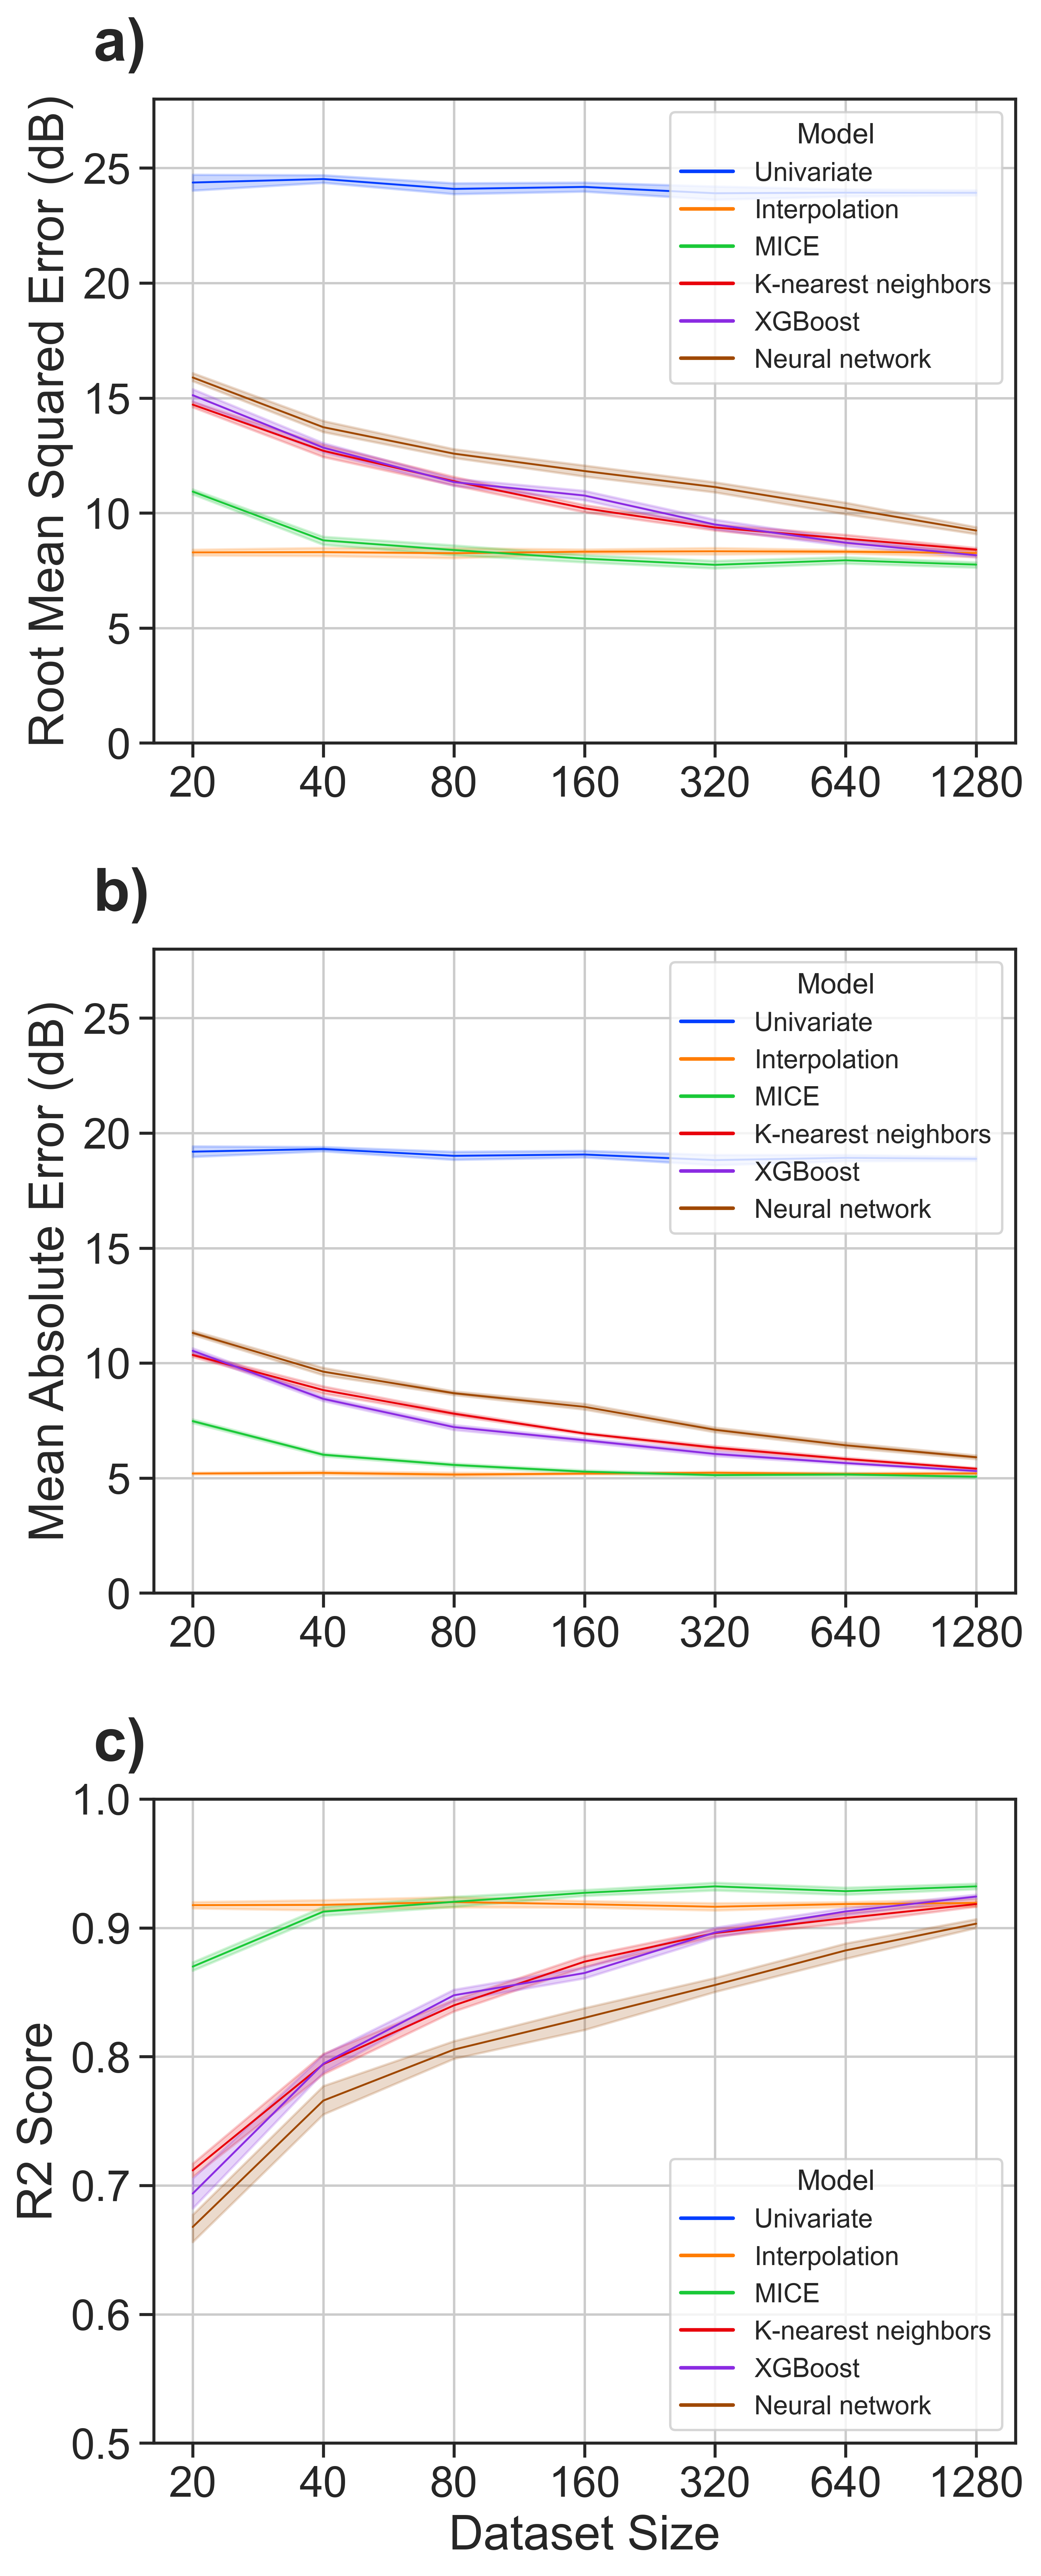

In [156]:
### Plot lineplot - sizes

save_path = '***.csv'
error = pd.read_csv(save_path)
error['Size'] = error['Size'].astype('string')


ci = 95
hue = 'Model'
x = 'Size'
xlim = (0, 1280)

sizes = [20, 40, 80, 160, 320, 640, 1280]


y_list = [
    'Root Mean Squared Error', 'Mean Absolute Error', 'R2 Score', 
   # '% Misses > 10'#, '% Errors > 20db', '% Errors > 30db'
]

ylim_list = [
    (0, 28),  # RMSE
    (0, 28),  # MAE
    (0.5, 1), # R2

    (0, 100),  # %>10
#     (0, 100),  # %>20
#     (0, 100),  # %>30

]



fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 17),  dpi=500, sharey=False)

_ = plt.subplots_adjust(
    left  = 0,  # the left side of the subplots of the figure
    right = 1,    # the right side of the subplots of the figure
    bottom = 0.1,   # the bottom of the subplots of the figure
    top = 0.9,      # the top of the subplots of the figure
    wspace = 0.3,   # the amount of width reserved for blank space between subplots
    hspace = 0.32,   # the amount of height reserved for white space between subplots
)

font_subheader = {'size': 20}
title_subheader = {'size': 25, 'weight': 'bold'}
abc_size=25
ticksize = 18

sns.set_theme()
palette = sns.color_palette('bright', error[hue].nunique())
sns.set_style("ticks", {'axes.grid': True})

n = 0
for y, ylim, ax in zip(y_list, ylim_list, axes.ravel()):
    
    if y in ['Root Mean Squared Error', 'Mean Absolute Error', 'R2 Score', '% Misses > 10', '% Errors > 20db', '% Errors > 30db']:

        _ = sns.lineplot(ax=ax,
                         x=x,
                         y=y,
                         hue=hue,
                         data=error,
                         err_style='band',
                         ci=ci,
                         palette=palette,
                         linewidth=0.8)

        _ = ax.set(ylim=ylim)#, xlim=xlim)
        
        _ = ax.set_xticklabels(sizes)
        
        _ = ax.tick_params(axis='x', labelsize=ticksize)
        _ = ax.tick_params(axis='y', labelsize=ticksize)
        
        if (y == 'Root Mean Squared Error') or (y == 'Mean Absolute Error'):
            y = y + ' (dB)'
            
        if y == '% Misses > 10':
            y = y + 'dB'
        
        _ = ax.set_ylabel(y, fontdict=font_subheader)
        
        if y in ['Root Mean Squared Error (dB)', 'Mean Absolute Error (dB)',]:
            _ = ax.set_yticks(np.arange(0, 30, 5))
        
        
        if n in [2]:
            _ = ax.set_xlabel('Dataset Size', fontdict=font_subheader)
        else:
            _ = ax.set_xlabel('', fontdict=font_subheader)
        
    else: 
        _ = sns.barplot(ax=ax,
                        x=hue,
                        y=y,
                        data=error,
                        palette=palette,
                        capsize=0.2,
                        errwidth=1)
        
    n += 1


for n, ax in enumerate(axes.flat):   
    
    
    _ = ax.text(-0.07, 1.06, (string.ascii_lowercase[n] + ')'), transform=ax.transAxes, 
            size=abc_size, weight='bold')
        
plt.show()

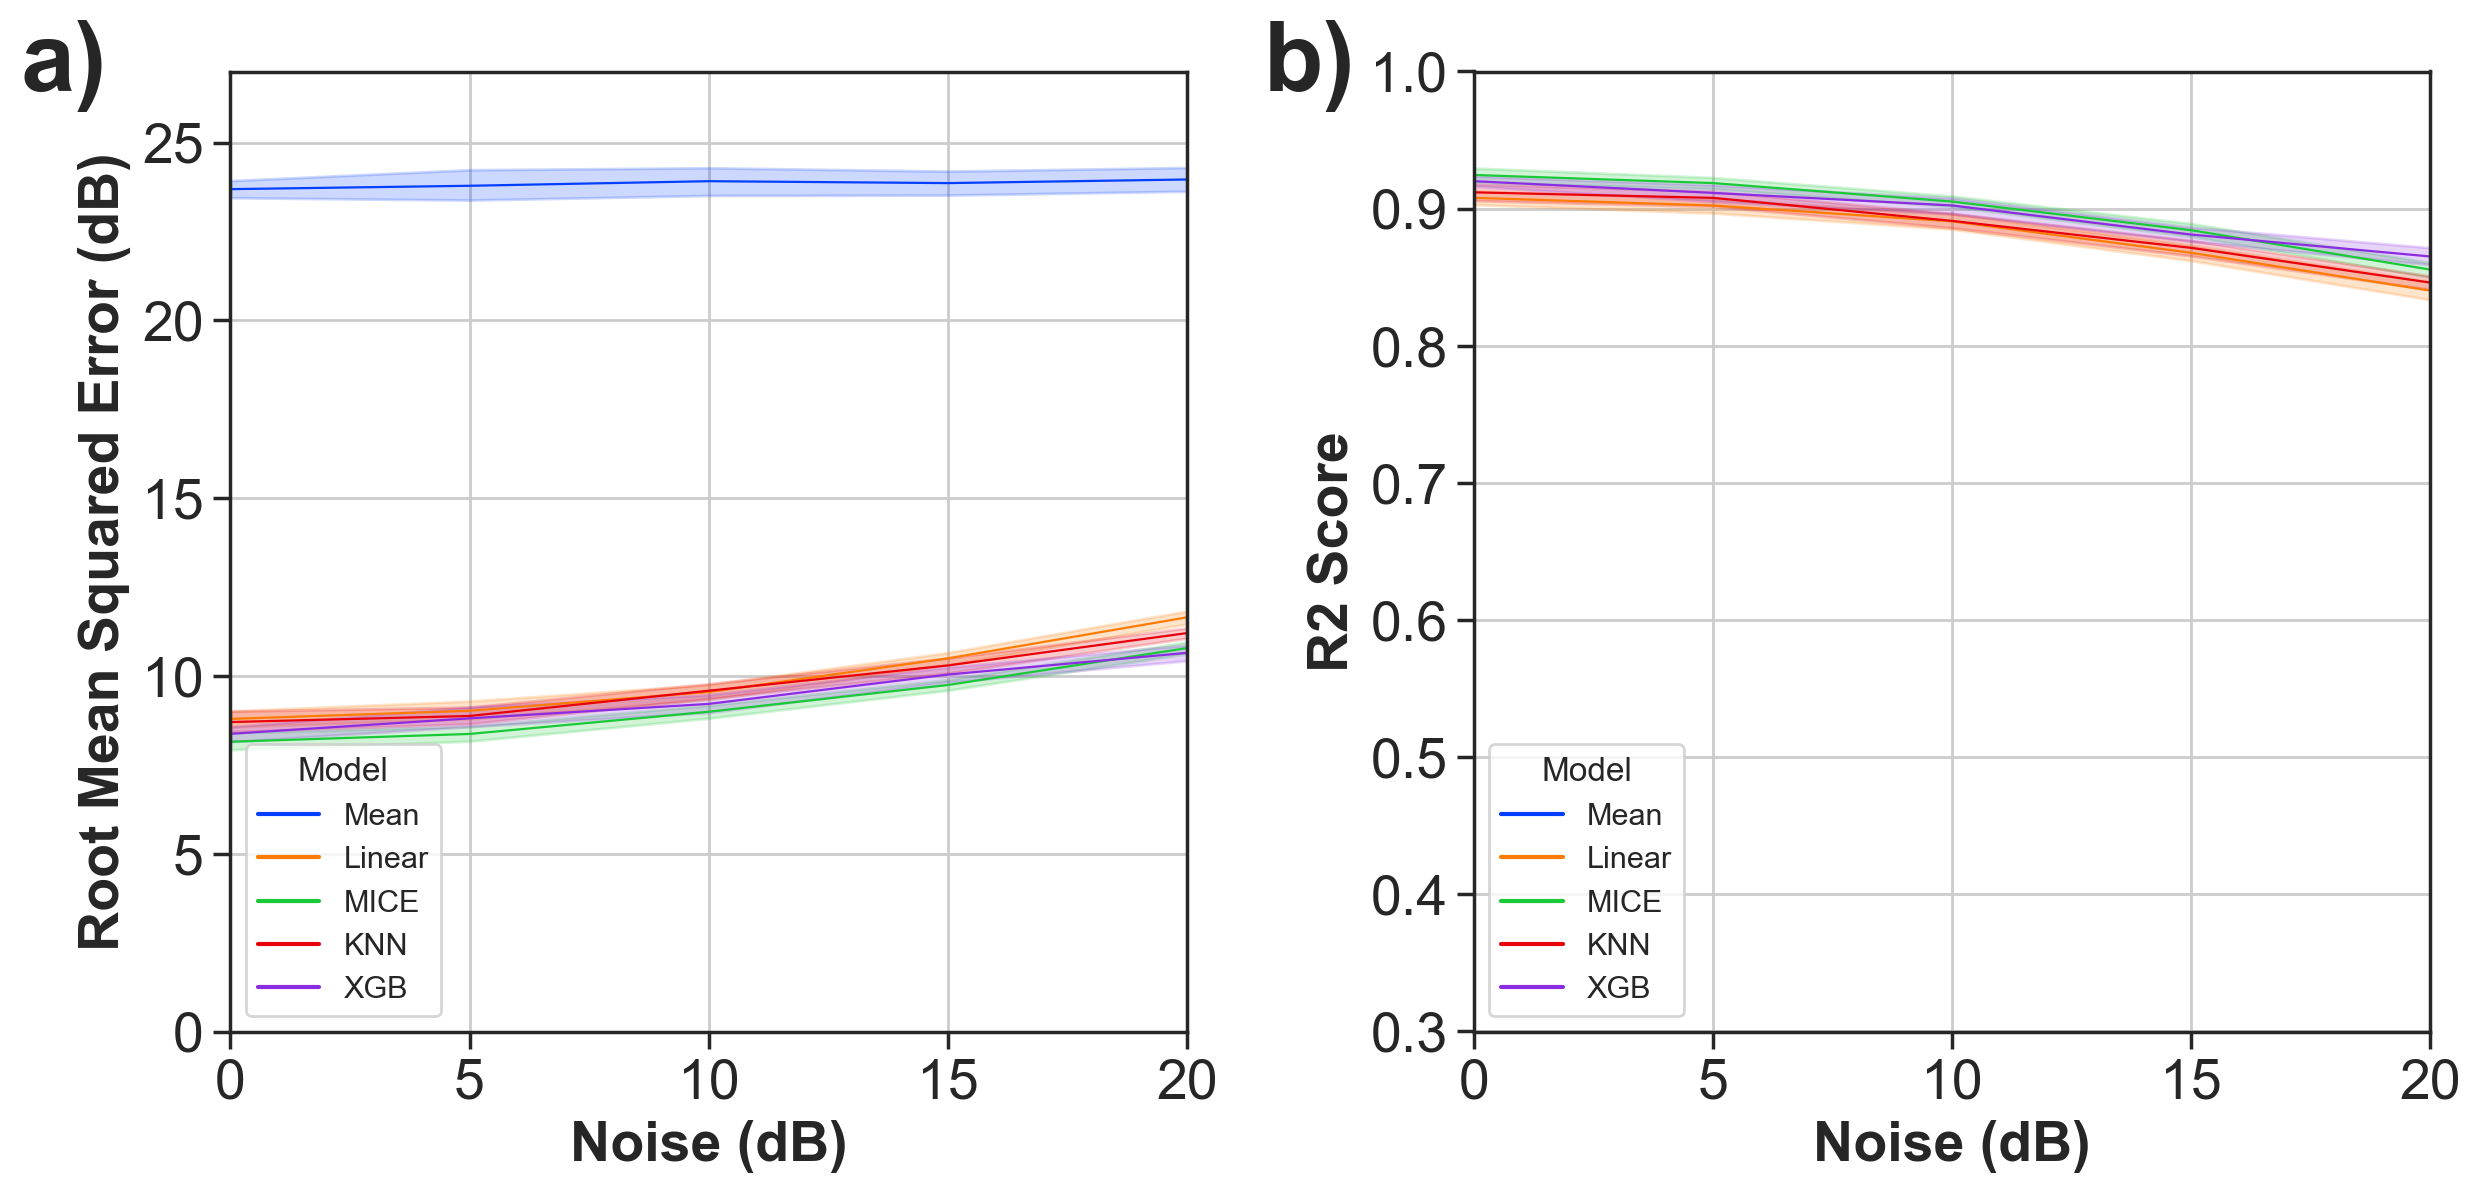

In [8]:
### Plot lineplot - Noise

#err_df = pd.read_csv('./Figures-AGI/9f_10x10f_1t8d.csv')

ci = 95
hue = 'Model'

x = 'Noise'
xlim = (0, 20)


y_list = [
    'Root Mean Squared Error', #'Mean Absolute Error', 
    'R2 Score', 
    #'% Misses > 10'#, '% Errors > 20db', '% Errors > 30db'
]

ylim_list = [
    (0, 27),  # RMSE
#     (0, 27),  # MAE
     (0.3, 1), # R2

#     (0, 100),  # %>10
#     (0, 100),  # %>20
#     (0, 100),  # %>30

]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 6),  dpi=200, sharey=False)

_ = plt.subplots_adjust(
    left  = 0,  # the left side of the subplots of the figure
    right = 1,    # the right side of the subplots of the figure
    bottom = 0.1,   # the bottom of the subplots of the figure
    top = 0.9,      # the top of the subplots of the figure
    wspace = 0.3,   # the amount of width reserved for blank space between subplots
    hspace = 0.24,   # the amount of height reserved for white space between subplots
)

font_subheader = {
    'size': 20,
    'weight': 'bold'
}

abc_size=35
ticksize = 20

#_ = plt.subplots_adjust(hspace=0.2, left=0, right=1)

sns.set_theme()
palette = sns.color_palette('bright', error[hue].nunique())
sns.set_style("ticks", {'axes.grid': True})

for y, ylim, ax in zip(y_list, ylim_list, axes.ravel()):
    
    if y in ['Root Mean Squared Error', 'Mean Absolute Error', 'R2 Score', '% Misses > 10', '% Errors > 20db', '% Errors > 30db']:

        _ = sns.lineplot(ax=ax,
                         x=x,
                         y=y,
                         hue=hue,
                         data=error,
                         err_style='band',
                         ci=ci,
                         palette=palette,
                         linewidth=0.8)

        _ = ax.set(ylim=ylim, xlim=xlim)
        
        _ = ax.set_xticks(np.arange(xlim[0], xlim[1]+1, 5))
        
        
        _ = ax.tick_params(axis='x', labelsize=ticksize)
        _ = ax.tick_params(axis='y', labelsize=ticksize)
        
        if (y == 'Root Mean Squared Error') or (y == 'Mean Absolute Error'):
            y = y + ' (dB)'
            
        if y == '% Misses > 10':
            y = y + 'dB'
        
        _ = ax.set_ylabel(y, fontdict=font_subheader)
        _ = ax.set_xlabel('Noise (dB)', fontdict=font_subheader)
        
        
    else: 
        _ = sns.barplot(ax=ax,
                        x=hue,
                        y=y,
                        data=error,
                        palette=palette,
                        capsize=0.2,
                        errwidth=1)


for n, ax in enumerate(axes.flat):   
    
    
    _ = ax.text(-0.22, 0.98, (string.ascii_lowercase[n] + ')'), transform=ax.transAxes, 
            size=abc_size, weight='bold')
        
plt.show()

In [6]:
def wilcox(error):
    main = 'MICE'
    
    comps = ['Univariate', 'Interpolation', 'K-nearest neighbors',
       'XGBoost', 'Neural network']
    
    dists = ['parent', 'random', 'skew-terminal', 'skew-central']
    
    errtypes = ['Mean Absolute Error', 'Root Mean Squared Error', 'R2 Score']
    
    
    for dist in dists:
        
        for comp in comps:
            
            for errtype in errtypes:
            
                x = error.loc[(error['Dist Type']==dist) & (error['Model']==main), errtype]
                
                y = error.loc[(error['Dist Type']==dist) & (error['Model']==comp), errtype]
                


                res = wilcoxon(x, y)

                print('{m1}:{m2}, dist:{d}, {e} -- {p}'.format(m1=main, m2=comp, d=dist, e=errtype, p=res.pvalue.round(7)))

                
def meanci(error):
    
    mdict = {
        'MI' : 'Mean Imputation',
        'LI' : 'Linear Interpolation',
        'MICE' : 'MICE',
        'KNN' : 'K-nearest neighbors',
        'XGB' : 'XGBoost',
        'NN' : 'Neural Network',
        'parent' : 'Real-world',
        'random' : 'Random',
        'skew-terminal' : 'Terminal',
        'skew-central' : 'Central'
    }

    error = error.replace(mdict)
    
    models = ['Univariate', 'Interpolation', 'MICE', 'K-nearest neighbors', 'XGBoost', 'Neural network']
    
    dists = ['Real-world', 'Random', 'Terminal', 'Central']
    
    errtypes = ['Mean Absolute Error', 'Root Mean Squared Error', 'R2 Score']
    
    maes = []
    rmses = []
    r2s = []
    
    outdict = {}
        
        
    for dist in dists:
    
        
        rows = []
        
        for model in models:

            row = []

            for errtype in errtypes:

                error_ = error.loc[(error['Dist Type']==dist) & (error['Model']==model), errtype]


                s = pd.DataFrame(sms.stats.descriptivestats.describe(error_, stats=['mean', 'ci'])).transpose()

                if errtype == 'R2 Score':
                    nd=3
                    
                else:
                    nd=2

                mean = s.loc[errtype, 'mean'].round(nd)
                lci = s.loc[errtype, 'lower_ci'].round(nd)
                uci = s.loc[errtype, 'upper_ci'].round(nd)

                row.append('{m} ({lci} - {uci})'.format(m=mean, lci=lci, uci=uci))
                           
                           
            rows.append(row)
                           
        
        #print(rows)
        

        sumdf = pd.DataFrame(data=rows, index=models, columns=errtypes)
        outdict[dist] = sumdf
                           
                           
    return outdict
        
                
                

wilcox(error)          
od = meanci(error)

NameError: name 'error' is not defined

In [23]:
sms.stats.descriptivestats.describe(error, stats=['mean', 'ci'])

Mean Absolute Error  Root Mean Squared Error  R2 Score  \
mean                 8.451624                11.936787  0.653284   
upper_ci             8.490597                11.981322  0.657724   
lower_ci             8.412651                11.892252  0.648844   

          Train Runtime  Prediction Runtime  % Misses > 10  % Misses > 20  \
mean          65.135320            0.871741      28.687182       9.362033   
upper_ci      65.598172            0.883375      28.851730       9.453605   
lower_ci      64.672467            0.860107      28.522635       9.270462   

          % Misses > 30  
mean           4.067207  
upper_ci       4.119330  
lower_ci       4.015084

In [80]:
def ttest(df, model, benchmarks, metrics):
    
    for metric in metrics:
        
        dfm = df.loc[df['Model'] == model, metric].values
        
        for benchmark in benchmarks:
            
            dfb = df.loc[df['Model'] == benchmark, metric].values
            
            pval = scipy.stats.ttest_ind(dfm, dfb)[1]
            
            adj_pval = pval * len(benchmarks)
            
            print(metric, ' - ', model, 'vs', benchmark, ': ', adj_pval)
            
        print('\n')

In [95]:
ttest(
    error, 
    'Feature Mean', 
    ['Feature Median', 'Feature Mode'],
    ['Root Mean Squared Error', 'Mean Absolute Error', 'R2 Score']
)

Root Mean Squared Error  -  Feature Mean vs Feature Median :  1.5883517861160147e-05
Root Mean Squared Error  -  Feature Mean vs Feature Mode :  1.8745029750224655e-27


Mean Absolute Error  -  Feature Mean vs Feature Median :  6.81896852305254e-05
Mean Absolute Error  -  Feature Mean vs Feature Mode :  2.596764939397107e-25


R2 Score  -  Feature Mean vs Feature Median :  5.0038254293187003e-17
R2 Score  -  Feature Mean vs Feature Mode :  8.896850059453187e-24




Text(0.5, 0, 'Frequency (Hz)')

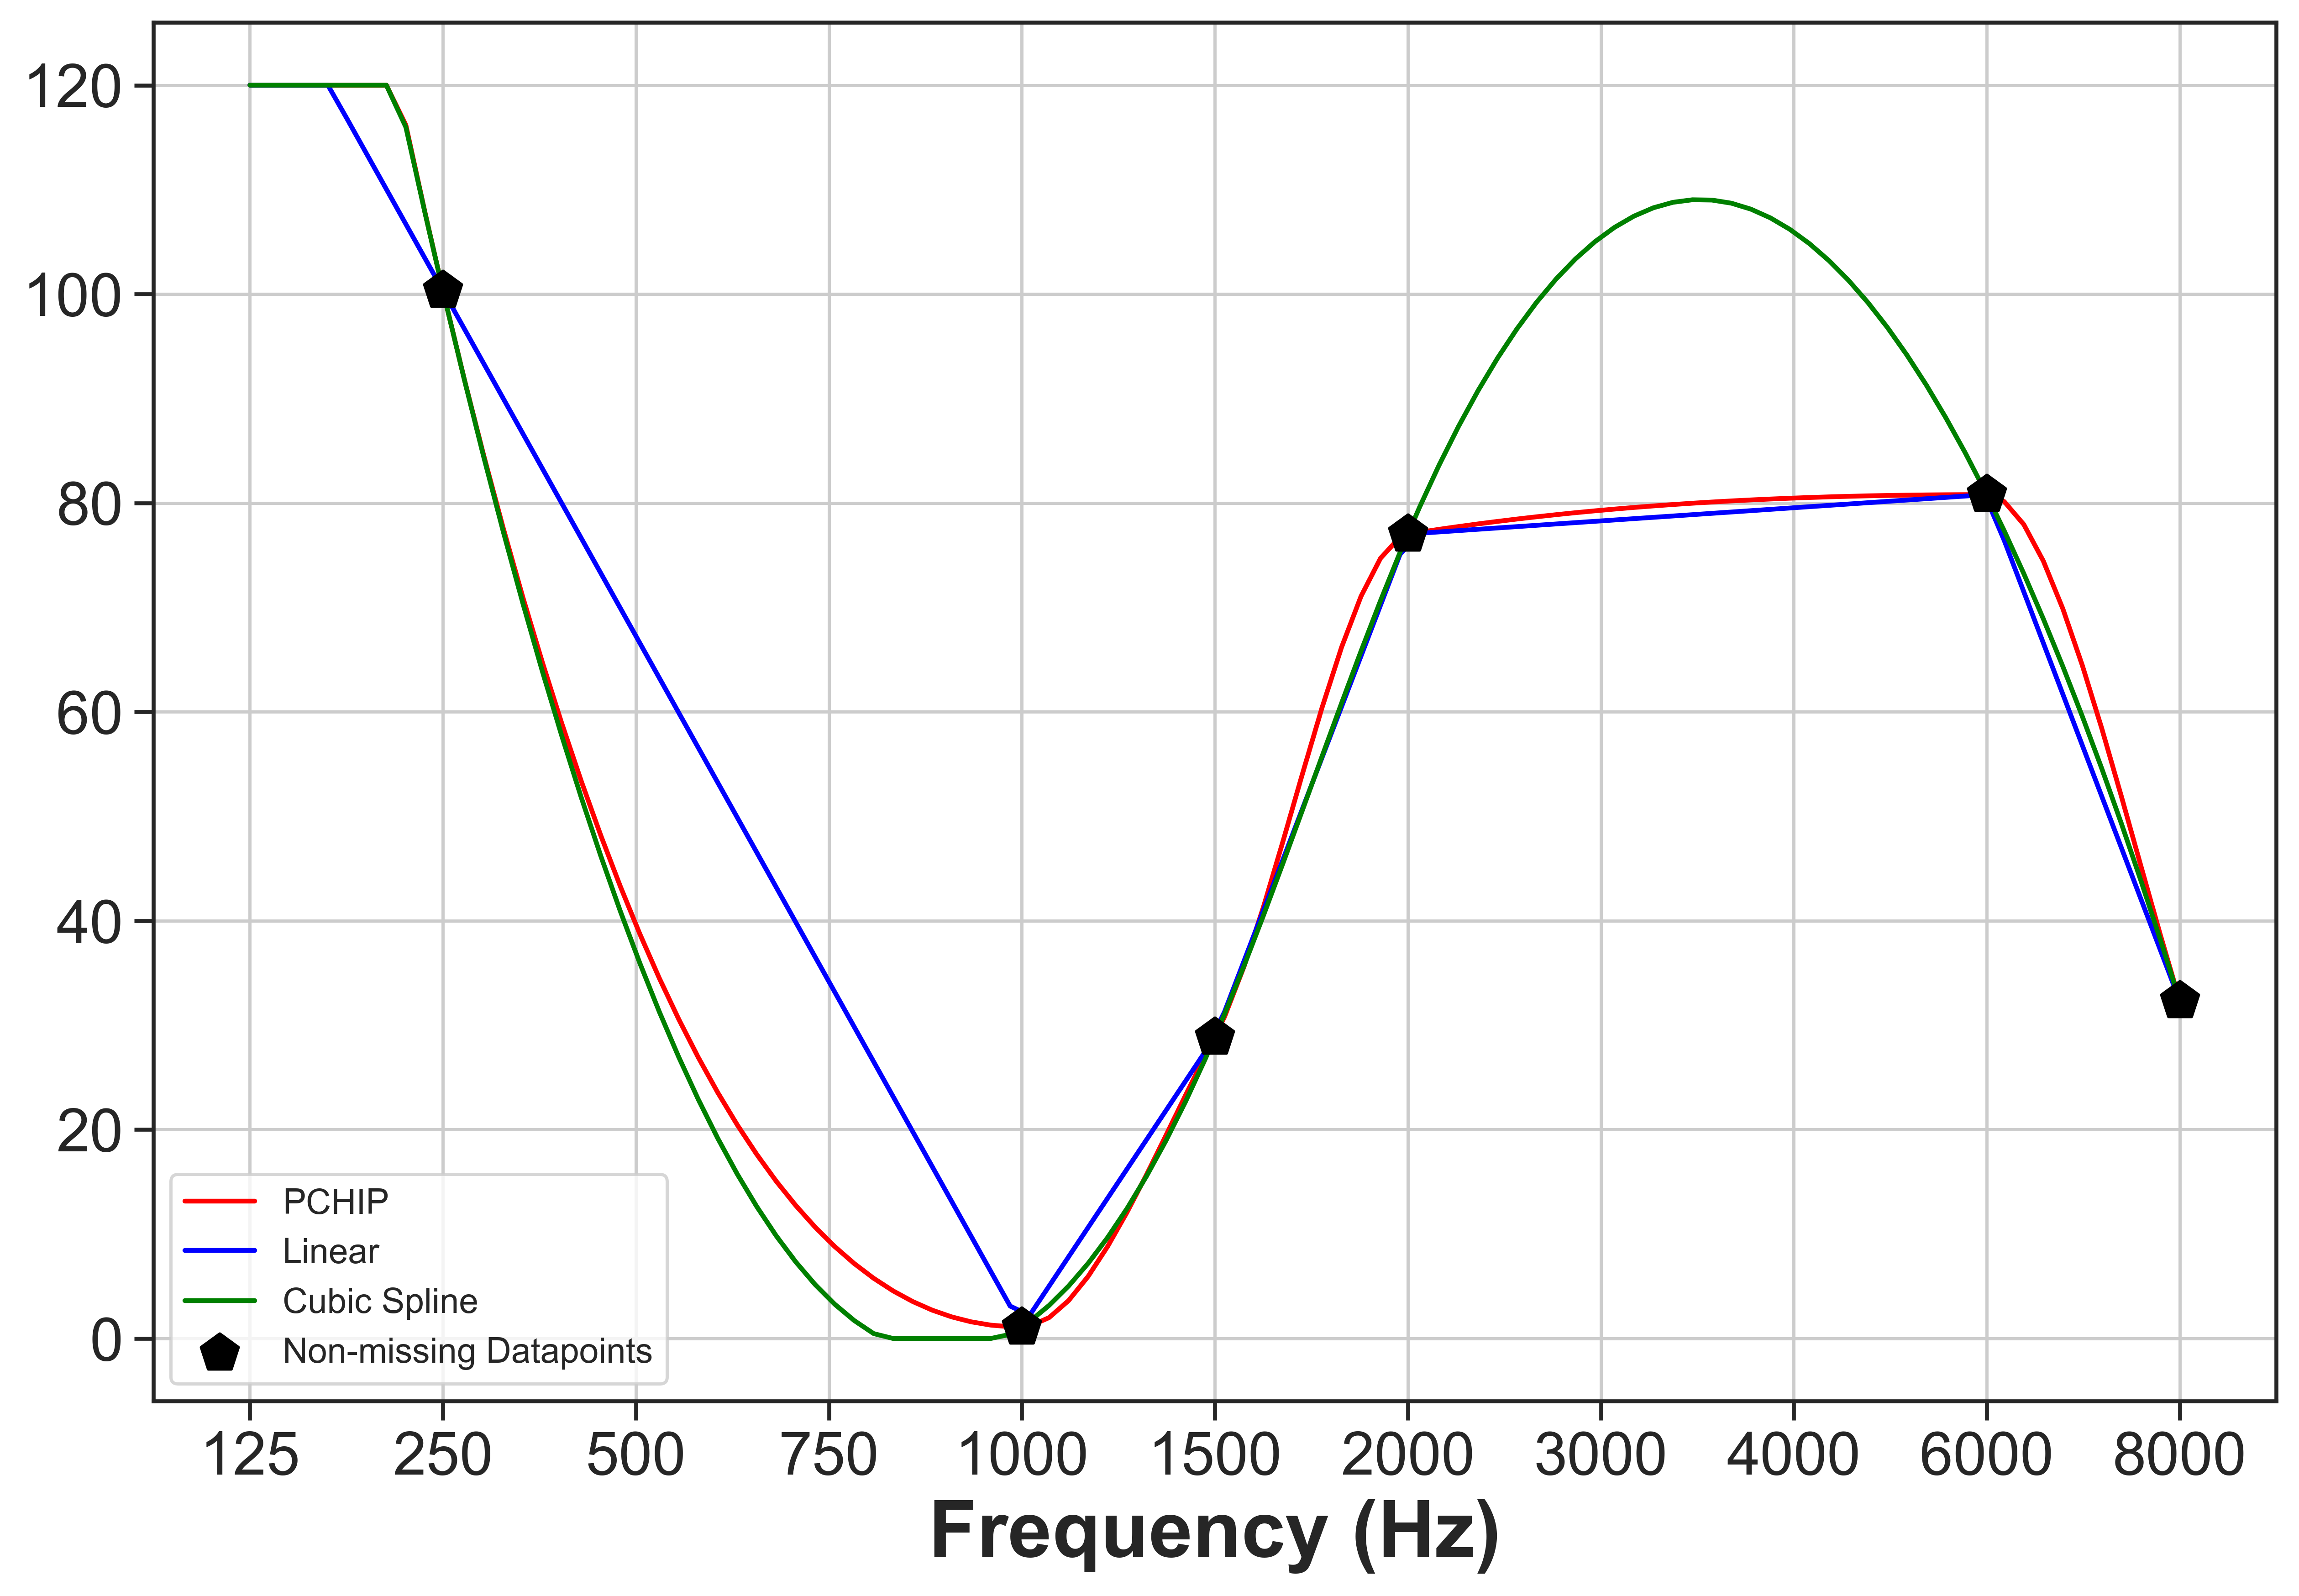

In [142]:
## Plot sample interpolate functions
import matplotlib.pyplot as plt
from scipy.interpolate import pchip_interpolate, interp1d, PPoly, CubicSpline, PchipInterpolator

fig, ax = plt.subplots(figsize=(12, 8),  dpi=500, sharey=False)


x_observed = np.array([1, 4, 5, 6, 9, 10])
y_observed = np.cos(x_observed/1.2)
y = (y_observed+1)*60

x = np.linspace(0, 10, num=100)

f = PchipInterpolator(x_observed, y_observed, extrapolate=True)
y1 = np.clip((f(x)+1)*60, a_min=0, a_max=120)

f = interp1d(x_observed, y_observed, fill_value='extrapolate')
y2 = np.clip((f(x)+1)*60, a_min=0, a_max=120)

f = CubicSpline(x_observed, y_observed, extrapolate=True)
y4 = np.clip((f(x)+1)*60, a_min=0, a_max=120)


ax.plot(x, y1, '-', label="PCHIP", color='red')
ax.plot(x, y2, '-', label="Linear", color='blue')
ax.plot(x, y4, '-', label='Cubic Spline', color='green')
ax.scatter(x_observed, y, s=150, marker='p', label="Non-missing Datapoints", color='black', zorder=2)
        
_ = ax.tick_params(axis='x', labelsize=19)
_ = ax.tick_params(axis='y', labelsize=19)
_ = ax.set_xticks(np.arange(0, 11, 1))

_ = ax.set_xticklabels(['125', '250', '500', '750', '1000', '1500', '2000', '3000', '4000', '6000', '8000'])

ax.legend()

ax.set_xlabel('Frequency (Hz)', fontsize=25, weight='bold')